# Suncal API User Manual: Guardbanding and False Accept Risk

Contrary to the other suncal calculation types, risk and guardbanding calculations do not use the model/result/report structure. Instead, suncal provides various functions for calculating false accept, false reject, and guardbands directly.
These functions operate using stats distributions from the scipy.stats library.

In [1]:
from scipy import stats
from suncal import risk

## Specific Risk

Specific risk is the probabilty that the result of a specific measurement is incorrect.
It is calculated using the `suncal.risk.specific_risk` function, providing it with the measurement distribution and upper and lower tolerance limits.
This function returns a tuple containing total risk (integrating the distribution outside the limits), along with the components of risk above the upper limit and below the lower limit, plus the Cpk value.

For example, if a measured value is 9.8, with 0.1 standard uncertainty, and the tolerance limits are between 9 and 10, the following calculation determines there is a 2.28% probability the measured value is out of tolerance. Essentially all of that probability is due to the upper limit, rather than the lower limit.

In [2]:
dist = stats.norm(loc=9.8, scale=.1)
LL, UL = 9, 10  # Lower and Upper Limits
risk.specific_risk(dist, LL=LL, UL=UL)

SpecificRisk(cpk=0.6666666666666642, total=0.022750131948180274, lower=6.220960574271382e-16, upper=0.022750131948179653)

This calculation may be visualized by plotting the stats distribution and limits. The risk is the integral of the distribution PDF curve that falls above the limit of 10.

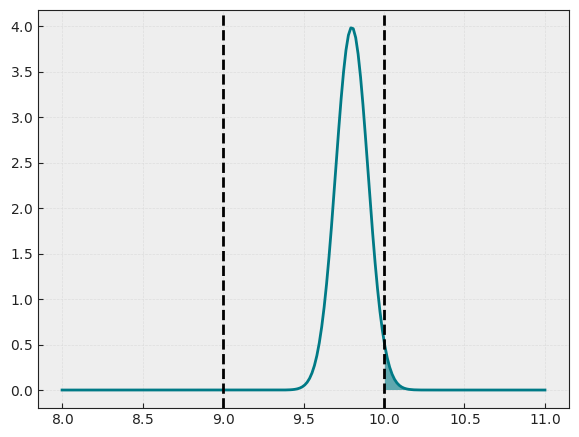

In [3]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(8, 11, num=200)
y = dist.pdf(x)
plt.plot(x, y)
plt.fill_between(x, y, where=x>UL, alpha=.6)
plt.axvline(LL, color='black', ls='--')
plt.axvline(UL, color='black', ls='--');

## Global Risk

Global risk accounts for the population of all devices under test, and gives the probability that ANY measurement on that population of devices is incorrect.
It is a combination of two probability distributions: the measurement uncertainty and the device population.
The `suncal.risk.PFA` function calculations probability of false acceptance (true value is out of tolerance but measurement indicates it is in-tolerance). The `suncal.risk.PFR` function calculates probabiliyt of false reject (true value is in tolerance but measurement indicates out-of-tolerance.)

Below, the products are distributed with mean of 9.5 and standard deviation of 0.3. Using the `specific_risk` function, we can determine that 9.5% of all products are be out of tolerance (a Cpk of 0.56).

In [4]:
products = stats.norm(loc=9.5, scale=.3)
risk.specific_risk(products, LL, UL)

SpecificRisk(cpk=0.5555555555555556, total=0.09558070454562939, lower=0.0477903522728147, upper=0.047790352272814696)

Rather than accepting a 9.5% out-of-tolerance risk from these products, each product is inspected with a measurement.
When this measurment is added, the risk of accepting any nonconforming product is calculated with `risk.PFA`, and is 1.9%.

In [5]:
measurement = stats.norm(loc=9.8, scale=.1)  # Loc doesn't matter
risk.PFA(products, measurement, LL=9, UL=10)

0.01894220671702191

The global false reject risk is also a useful metric, since false rejects increase costs.

In [6]:
risk.PFR(products, measurement, LL=9, UL=10)

0.037207800178056825

## Guardbanding

Guardbands reduce the false accept limits by only accepting products within a smaller, guardbanded, limit.
There are many methods for computing guardbands, often based on test uncertainty ratio (TUR).
However, suncal provides functions for computing guardbands that result in an exact probability of false accept.

Suppose the products above should have no more than 0.5% false accept probabilty for quality control purposes.
A guardband that results in this level of risk may be calculated using `suncal.risk.guardband.target` and supplying the distributions, limits, and target PFA value.
The guardband value is solved using numerical minimization techniques, to solve the PFA integral for the integration limits that result in the desired PFA.

In [7]:
gb = risk.guardband.target(products, measurement, LL=LL, UL=UL, target_PFA=0.005)
gb

0.0920660454857833

This value is an absolute offset to apply to the upper and lower limits, illustrated below. Acceptance limits are $LL+gb$ and $UL-gb$.

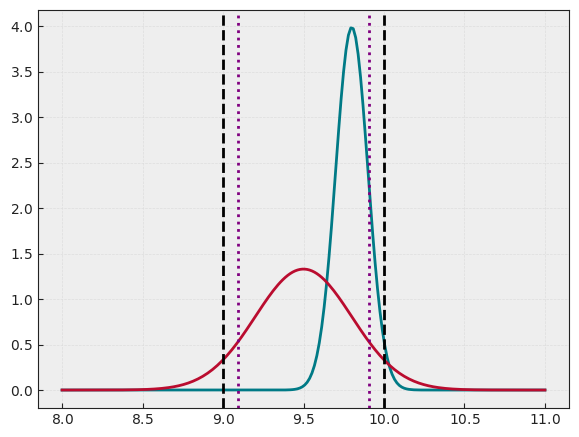

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(8, 11, num=200)
y = measurement.pdf(x)
yproduct = products.pdf(x)
plt.plot(x, y)
plt.plot(x, yproduct)
plt.axvline(LL, color='black', ls='--')
plt.axvline(UL, color='black', ls='--')
plt.axvline(LL+gb, color='purple', ls=':')
plt.axvline(UL-gb, color='purple', ls=':');

## Normal Distributions

If the distributions are normal and defined in terms of test uncertainty ratio and in-tolerance probability (sometimes called end-of-period-reliability), the `suncal.risk.PFA_norm` and `suncal.risk.PFR_norm` functions are more efficient to compute.
Here, the GB parameter is the guardband *factor*, which is the fraction of the tolerance to accept: with a guardband factor of 0.9 and original tolerance of +/- 10, the guardbanded tolerance is +/- 9.

In [9]:
risk.PFA_norm(itp=0.9, TUR=3)

0.017141521741767578

In [10]:
risk.PFA_norm(itp=0.9, TUR=3, GB=0.9)

0.007613233268618118

## Arbitrary Distributions

The risk functions work on any probability distribution available in scipy.stats.
Below is an example of using a gamma distribution, which is recommended by "JCGM 106:2012 - The role of measurement uncertainty in conformity assessment" for values that are near, but cannot go below, zero.

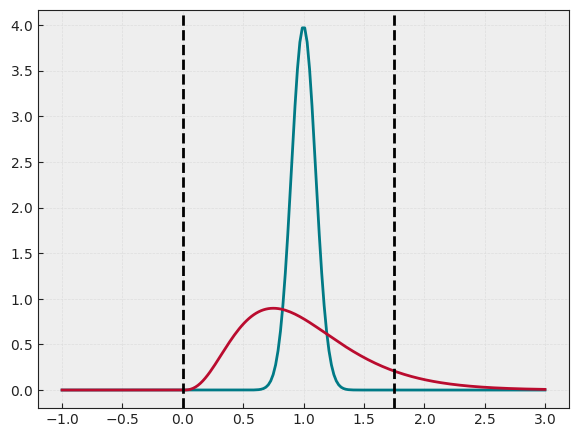

In [11]:
products = stats.gamma(a=4, scale=.25)
measurement = stats.norm(loc=1, scale=0.1)
LL = 0
UL = 1.75

x = np.linspace(-1, 3, num=200)
y = measurement.pdf(x)
yproduct = products.pdf(x)
plt.plot(x, y)
plt.plot(x, yproduct)
plt.axvline(LL, color='black', ls='--')
plt.axvline(UL, color='black', ls='--');

In [12]:
risk.PFA(products, measurement, LL, UL)

0.007238933668308192

See the **Risk - Ball Bearing** example for more examples of risk involving non-normal distributions.

## Curves

False accept curves, such as the figures in "A Guard Banding Strategy for Managing False Accept" by Michael Dobbert of Agilent, may be created by looping the risk functions. See the **Risk - Curves** notebook for additional examples.

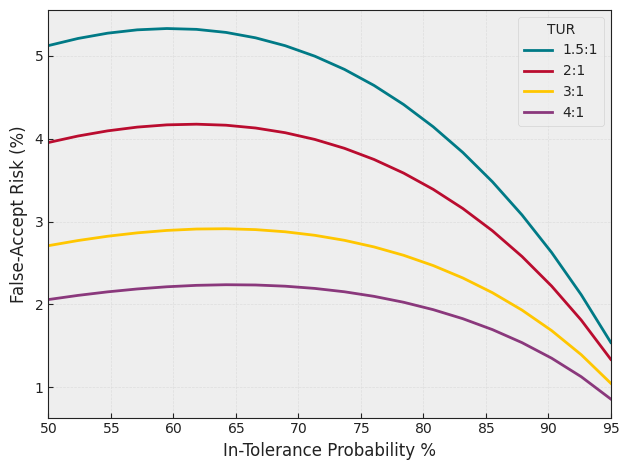

In [13]:
itplist = np.linspace(50, 95, num=20) / 100
TURlist = np.array([1.5, 2, 3, 4])

for i, TUR in enumerate(TURlist):
    PFA = np.zeros(len(itplist))
    for j, itp in enumerate(itplist):
        PFA[j] = risk.PFA_norm(itp, TUR)
    plt.plot(itplist*100, PFA*100, label='{:g}:1'.format(TUR))

plt.xlabel('In-Tolerance Probability %')
plt.ylabel('False-Accept Risk (%)')
plt.xlim(50, 95)
plt.legend(fontsize=10, title='TUR')
plt.tight_layout()